╔══<i><b>Public-AI</b></i>═══════════════════════════════════════════════════╗
### ✎&nbsp;&nbsp;week 3. Matrix Factorization
# Section 1. Matrix Factorization의 기본 개념

지난 시간까지 고객이 자신의 선호를 직접 별점으로 남긴 리뷰 데이터를 이용해 추천 시스템을 만들어보았습니다. 하지만 고객의 기호를 직접적으로 알 수 있는 데이터(평점 데이터 혹은 리뷰 데이터)를 항상 얻을 수 있는 건 아닙니다. 보통은 이벤트 로그 또는 구매 빈도 등 고객의 행동이 기록된 데이터를 통해 "많이 찾는 것 = 선호하는 것"이라고 가정을 하고 시스템을 만들어야 합니다. 이렇게, 고객이 선호를 직접 표현하지 않은 행동 데이터를 "암묵 데이터(Implicit Data)"라고 합니다. 이번 시간에는 고객 행동 데이터로부터 유저의 취향 혹은 아이템의 특성을 수치화는 Matrix Factorization의 개념을 배워보고, 이를 추천시스템으로 활용하는 방법을 알아봅시다.

### _Objective_ 

* **[문제 정의]** 고객행동 데이터 중 암묵적 데이터를 이용해 추천시스템을 만드는 문제를 정의하고, 이번 주차에 다룰 Last.fm 데이터 확인해보겠습니다. 
* **[기본 개념 : Embedding과 Matrix Factorization]** 고객행동 데이터에서 추천 항목을 도출해 낼 수 있는 Matrix Factorization의 기본 개념을 알아봅니다.
<br>

╚═══════════════════════════════════════════════════════════╝

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.utils import get_file
np.set_printoptions(3)

# \[ 문제 정의 \]
---

고객의 행동을 나타내는 데이터는 크게 "형식데이터(Explicit Data)"와 "암묵데이터(Implicit Data)"로 구분됩니다. <br>
형식데이터는 고객이 직접 선호를 드러낸 "평가점수(Rating)"이나 "후기(Review)" 등을 의미합니다. <br>
한편, 암묵 데이터에는 고객이 직접 선호를 드러내지는 않았지만 소비 활동에서 자연스럽게 기록된 "페이지 뷰 로그","장바구니 담기 기록", "구매" 등이 있습니다. <br>
"고객은 선호하는 장르의 아이템에 대해서는 로그를 여러번 발생시킨다"고 가정하고, 이를 통해 암묵적으로 사용자의 취향을 알 수 있다고 하여 붙은 이름입니다. <br>
<br>
좀 더 구체적은 예를 들어 이번 주차에 다룰 문제를 살펴봅시다. 현업에서는 이벤트 로그 데이터의 집계를 통해 아래와 같은 횟수 데이터를 생성할 수 있습니다.<br>
<br>

|User_id|Item_id|Count|
|---|---|---|
|0001|1110|3|
|0001|1113|5|
|0001|1117|1|
|0002|1110|2|
|0002|1120|1|
|...|...|...|


암묵 데이터는 형식 데이터와 달리 몇가지 특징을 가집니다. 
1. 주로 View, Add-to-Cart, Buy등 긍정적 반응이 기록됩니다. 
2. 고객이 직접 선호를 드러내지 않아도 되기 때문에(유저가 선호 여부를 기록하는 행위를 하지 않아도 되기 때문에) 형식적 데이터보다는 밀집(Dense)되어 있습니다. 
3. 데이터에서 유저의 선호를 파악하기 위해서는 도메인 지식을 활용하여 휴리스틱하게 접근해야 합니다.

종합해보면, 이번 주차에 다룰 문제 혹은 데이터셋은 다음과 같이 정리할 수 있습니다.
1. 유저(User) 별 아이템(Item) 에 대한 상호작용 데이터
1. 그 중 암묵 데이터(Implicit Data) 활용
1. 그 중 유저 별 각 아이템에 대한 행동 횟수 데이터 활용

유저의 행동 데이터, 고객의 행동에서 암묵적으로 선호가 드러난 암묵 데이터인 Last.fm 데이터를 이용해, 각 유저에게 아이템을 추천해주는 추천시스템을 만들어보겠습니다. 

## 1. Last.fm 데이터 살펴보기

![w3_1](https://i.imgur.com/nEWiz4e.png)

이러한 문제 정의에 부합하는 실무 데이터인 Last.fm 데이터를 살펴보겠습니다.<br>
Last.fm 데이터는 음악 스트리밍 서비스를 사용하는 유저가 어떤 음악을 들었는지가 담겨진 데이터입니다.<br>
데이터는 아래 세 가지로 나뉩니다. 
- `player_df` : 각 유저의 아티스트별 재생 횟수 (상호작용 데이터)
- `artist_df` : 아티스트 정보 (아이템에 대한 데이터)
- `user_df` : 유저 정보 (사용자에 대한 데이터)

데이터를 불러와 살펴봅시다.

In [2]:
ROOT_URL = "https://pai-datasets.s3.ap-northeast-2.amazonaws.com/recommender_systems/lastfm/prep/"

# 데이터 가져오기
play_path = get_file("lastfm_play.csv", ROOT_URL+"lastfm_play.csv")
artist_path = get_file("lastfm_artist.csv",ROOT_URL+"lastfm_artist.csv")
user_path = get_file("lastfm_user.csv", ROOT_URL+"lastfm_user.csv")

play_df = pd.read_csv(play_path)
artist_df = pd.read_csv(artist_path)
user_df = pd.read_csv(user_path)

**문제정의와 부합하는 데이터 확인**<br>

먼저 상호작용 데이터를 살펴봅시다. `player_df`는 유저별 아티스트의 노래를 얼마나 재생했는지에 대한 데이터입니다. 각 칼럼의 의미는 아래와 같습니다.

* user_id : 유저(user) 식별자<br>
* artist_id  : 아티스트(item) 식별자<br>
* plays    : 각 유저의 아티스트 소비(재생) 횟수<br>

In [3]:
print("play_df의 크기 : ", play_df.shape)

# 5개를 Random으로 가져옴
play_df.sample(5, random_state=1)

play_df의 크기 :  (17302623, 3)


user_id  artist_id  plays
7374310    153017      25808    123
457097       9475         62     20
13284433   275810       4217     52
6406613    133005       2632     45
2074779     43062        266    186

그리고 추가적으로 해당 유저의 신상 정보(`user_df`)와 아티스트의 이름(`artist_df`)은 다음과 같습니다. 

In [4]:
print("user dataframe")
display(user_df.head())

print("artist dataframe")
display(artist_df.head())

user dataframe


user_id gender  age        country
0        0      f   22        Germany
1        1      f   -1         Canada
2        2   None   -1        Germany
3        3      m   19         Mexico
4        4      m   28  United States

artist dataframe


artist_id           artist_name
0          0       betty blowtorch
1          1             die Ärzte
2          2     melissa etheridge
3          3             elvenking
4          4  juliette & the licks

## 2. 데이터 탐색하기

본격적으로 추천시스템을 만들기에 앞서 기본적인 데이터의 특성을 탐색해봅시다. <br>
`play_df`데이터에서 유저를 기준으로 데이터를 탐색해보기도 하고, 아티스트를 기준으로 데이터를 탐색해보기도 하겠습니다.

**(1) 유저 별 평균 몇 명의 아티스트 음악을 재생했는지 보기**

유저 별로 몇 명의 아티스트의 음악을 재생했는지 봅시다.

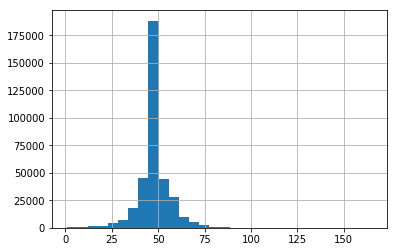

In [5]:
(
    play_df
    .groupby('user_id')
    ['artist_id']
    .count()
    .hist(bins=30)
)
plt.show()

평균 50명 내외의 아티스트의 음악을 재생하는 것을 알 수 있습니다. 

**(2) 아티스트 별로 몇 명의 유저가 재생했는지 보기**

이번에는 아티스트를 기준으로 볼까요? 각 아티스트마다 몇 명의 유저가 음악을 들어줬는지 봅시다. 

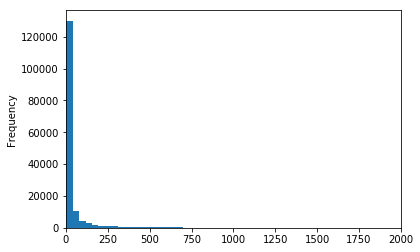

In [6]:
(
    play_df
    .groupby('artist_id')
    ['user_id']
    .count()
    .plot(kind='hist',bins=2000, xlim=(0,2000))
)
plt.show()

그래프가 왼쪽으로 치우친 형태입니다. 250명 이상의 유저가 들은 인기있는 아티스트 아티스트는 극히 일부인 것을 알 수 있습니다. 대부분의 아티스트는 50명 이내의 유저가 들은 기록을 가지고 있습니다. 

**(3) 유저 별로 아티스트의 음악을 평균 몇 번 재생했는지 보기**

이번에는 유저별로 각 아티스트의 음악을 몇 번이나 들었는지 알아보겠습니다. 

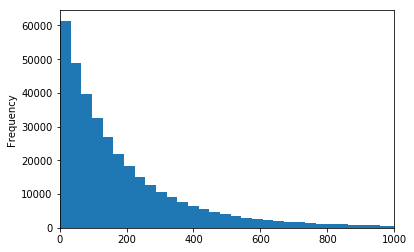

In [7]:
(
    play_df
    .groupby('user_id')
    ['plays']
    .mean()
    .plot(kind='hist',xlim=(0,1000),bins=2000)
)
plt.show()

평균 적으로 아티스트 별 213회 정도의 재생이 일어났는데, 중간 값은 이보다 작은 125회이고, 최대 재생 횟수는 6만 회가 넘습니다. <br>
그래프가 왼쪽으로 치우쳐져 있다는 것을 이 차이를 통해서도 알 수 있습니다. 

In [8]:
avg_plays_per_user_id = (
    play_df
    .groupby('user_id')
    ['plays']
    .mean()
)

print("유저 별 평균 재생 횟수 :", avg_plays_per_user_id.mean())
print("유저 별 중간값 재생 횟수 :", avg_plays_per_user_id.median())
print("유저 별 최대 재생 횟수 :", avg_plays_per_user_id.max())

유저 별 평균 재생 횟수 : 213.99843014743578
유저 별 중간값 재생 횟수 : 125.15789473684211
유저 별 최대 재생 횟수 : 63703.0


# \[ 기본 개념 \] : Embedding과 Matrix Factorization
---


## 1. Matrix Factorization

지난 시간까지 추천 시스템의 데이터 중에서 고객 정보와 아이템 정보를 활용하여 추천하는 방식인 **콘텐츠 기반 필터링(Content-Based Filtering)** 과 고객과 아이템 간 상호 작용 정보를 활용하여 추천하는 방식인 **협업 필터링(Collaborative Filtering)**을 배웠습니다. <br>

지난 시간에 배운 아이템 기반 협업 필터링(Item-Based Collaborative Filtering)은 모델 학습 없이 명시적 데이터를 활용해 아이템 간 유사도를 계산하여 아이템을 추천하는 방식으로, 메모리 기반 협업 필터링(Memory-Based Collaborative Filtering)이라 부르기도 합니다.  <br>

이번 시간에는 고객행동 데이터로부터 아이템 및 고객의 특성을 추론하여 유사도를 계산하는 **모델 기반 협업 필터링(Model-Based Collaborative Filtering)** 중 대표적인 알고리즘인 Matrix Factorization을 배워보도록 하겠습니다.


## 2. 취향과 특성을 수치화하는 방법, 임베딩(Embedding)


특정 고객의 **취향**이 특정 제품의 **특성**과 맞아떨어졌을 때, 특정 고객이 특정 제품을 선호한다라고 말할 수 있습니다. <br>
고객의 취향과 제품의 특성이 맞아 떨어진다는 걸 어떻게 수치화할 수 있을까요? <br>
<br>
이전 시간에 유사도 개념을 배웠습니다. 유사도란 두 벡터가 얼마나 비슷한 값을 가지고 있는지를 나타내는 지표입니다.<br>
이번에도 유사도를 활용할 수 있지 않을까요? <br>
<br>
고객의 취향을 벡터로 바꾸고 제품의 특성을 벡터로 바꾼다면, 고객의 취향이 특정 제품의 특성과 얼마나 잘 맞아 떨어지는지 유사도를 통해 계산할 수 있을 것입니다.<br>
이처럼 특정한 개념(취향 / 특성)을 숫자로 표현하는 방식을 임베딩(Embedding)이라 부릅니다.<br>
<br>
예를 들어 청취자와 아티스트의 음악 취향을 아래처럼 수치로 나타낼 수 있다면, 취향에 맞는 아티스트(아이템)을 찾아줄 수 있을 것입니다.<br>

| 청취자 | 재미있는 | 호소력 | 로맨틱 | - | 아티스트 | 재미있는 | 호소력 | 로맨틱 |
| ---- | --- | ----  | ---- | ---- | --- | ----  | ---- | ---- |
| A | 0.8 | 0.2 | 0.5 | - | 장기하와 아이들 | 0.8 | 0.3 | 0.2 |
| B | 0.3 | 0.7 | 0.4 | - | 자우림 | 0.4 | 0.6 | 0.6 |
| C | 0.2 | 0.5 | 0.9 | - | 데이브레이크| 0.1 | 0.7 | 0. 7 |
| D | 0.6 | 0.4 | 0.4 | - | 국카스텐 | 0.2 | 0.9 | 0.3 | 


앞서 살펴본 상호작용 데이터로부터 위와 같은 특성 정보를 뽑아내는 임베딩 방법 중 하나가 바로 이번 시간에 배울 Matrix Factorization입니다. 

## 3. Matrix Factorization의 의미

Matrix Factorization이란, 주어진 고객과 제품 간의 선호 행렬로부터 고객의 취향 정보 행렬과 제품의 특성 정보 행렬을 도출하는 과정을 의미합니다. <br>
Last.fm 데이터 맥락에 적용하여 생각해볼까요?<br>
Matrix Factorization을 하면, 유저-아티스트(User-Artist) 행렬에서 유저의 취향 행렬과 아티스트의 특성 행렬을 도출할 수 있을 것입니다. 

<img src="https://i.imgur.com/QnC5xQx.png" height="150" width="800" >
<br>
위의 그림을 다르게 묘사하면 아래와 같습니다.
<br>
<img src="https://i.imgur.com/zvx2JNs.png" height="150" width="400" >

이렇게 유저의 취향 행렬과 제품의 특성 행렬을 얻게 되면 어떤 이점이 있을까요?<br>
크게 3가지의 작업을 할 수 있게 됩니다.<br>
- Rating Prediction : 유저가 경험해보지 않은 아이템에 대한 선호도 예측하기
- User Clustering : 유사한 취향을 가진 유저 묶기 
- Item Clustering : 유사한 특성을 가진 아이템 묶기

<br>


Last.fm 데이터셋에 적용한다면 어떤 작업이 될까요? 

### (1) 청취자가 들어보지 않은 아티스트 중에서 좋아할 만한 아티스트를 선별하기 (Rating Prediction)


<img src="https://i.imgur.com/H6WsvG5.png" height="150" width="400" >

유저 행렬(User Matrix)과 아티스트 행렬(Artist Matrix)을 얻게 되면, 선호도 행렬(Rating Matrix)에서 몰랐던 값인 물음표(?) 자리를 메꿀 수 있게 됩니다. <br>
유저가 들어보지 않았던 아티스트의 선호도 예측이 가능하다는 얘기입니다.

### (2) 청취자들 중 유사한 음악 취향을 가진사람들을 묶기 (User Clustering)

<img src="https://i.imgur.com/cASBZMN.png" height="150" width="350" >
<br>

고객의 취향 행렬을 얻게 되면 고객 중 유사한 음악 취향을 가진 사람들끼리 묶는 고객 클러스터링 작업을 진행하여 유저별 특성을 분석하는 작업도 가능해집니다.

### (3) 아티스트 별 유사한 음악적 특성을 가진 아티스트들을 묶기 (Item Clustering)

<img src="https://i.imgur.com/3xKo1sD.png" height="200" width="500" >

아이템 특성 행렬을 얻게 되면, 고객과 마찬가지로 아이템 클러스터링을 해볼 수도 있을 것입니다. <br>
또한 이전 시간에 다루었던 아이템 기반 협업 필터링처럼 특정 아티스트와 비슷한 아티스트를 추천할 수도 있게 됩니다.

## 4. Item-Based Collaborative Filtering과의 Matrix Factorization의 차이

이전 시간에 배운 아이템 기반 협업 필터링(Item-Based Collaborative Filtering)은 아이템 간 유사도 행렬 혹은 유저 간 유사도 행렬을 생성하여 유사한 아이템 혹은 유사한 유저가 선호한 아이템을 추천합니다. <br>
별도의 학습 과정(혹은 특성 추출 과정) 없이 전체 정보를 바로 연산에 사용하기 때문에 메모리 기반 협업 필터링(Memory-Based Collaborative Filtering)이라고도 합니다.<br>
아이템 기반 협업 필터링은 모델 학습 시간 없어 비교적 빠르게 추천할 수 있다는 점에서 유용하지만, **뻔한 추천**을 한다는 점에서 약점이 존재합니다.<br>
<br>
이번 시간에 다룰 Matrix Factorization은 유저와 아이템 간 상호작용 정보를 바탕으로 유저의 취향과 아이템의 특성을 뽑아냅니다.<br>
유저의 취향과 아이템의 특성은 위와 같이 임베딩 행렬로 만들어내는 **학습 과정**이 필요하기 때문에 모델 기반 협업 필터링(Model-Based Collaborative Filtering)이라고도 합니다.<br>
유저의 취향과 아이템의 특성을 있는 그대로 사용하지 않고, 상호작용 데이터로부터 추론하여 추천하기 때문에 좀 더 다양한 형태의 추천을 끌어낼 수 있다는 장점이 있습니다.
<br>

<img src="https://i.imgur.com/JzZKsvM.png"  width="800" >


## 5.  취향과 특성 임베딩을 통해 선호도를 파악하기, 행렬곱 연산


임베딩으로 유저의 취향 정보와 아이템의 특성 정보를 얻었다면, 앞서 언급한 대로 이 둘 사이의 유사도를 계산해야 합니다. <br>
이전 시간에 벡터 간 유사를 계산하는 알고리즘으로 코사인 유사도(Cosine Similarity)를 배웠었습니다. 그 수식은 아래와 같습니다.<br>

$$
sim(X,Y) = \frac{X\cdot Y}{|X||Y|}
$$

예제 데이터를 생성하여 유저 취향 행렬과 아이템 특성 행렬 사이의 코사인 유사도를 계산해봅시다. 


In [9]:
listeners = pd.DataFrame([
    [0.8, 0.2, 0.5],
    [0.3, 0.7, 0.4],
    [0.2, 0.5, 0.9],
    [0.6, 0.4, 0.4]], 
    columns=['재미있는','호소력','로맨틱'], 
    index=['A','B','C','D'])
print("유저 취향 행렬")
display(listeners)

artists = pd.DataFrame([
    [0.8, 0.3, 0.2],
    [0.4, 0.6, 0.6],
    [0.1, 0.7, 0.7],
    [0.2, 0.9, 0.3]],
    columns=['재미있는','호소력','로맨틱'],
    index=['장기하','자우림','데이브레이크','국카스텐'])
print("아티스트 특성 행렬")
display(artists)

유저 취향 행렬


재미있는  호소력  로맨틱
A   0.8  0.2  0.5
B   0.3  0.7  0.4
C   0.2  0.5  0.9
D   0.6  0.4  0.4

아티스트 특성 행렬


재미있는  호소력  로맨틱
장기하      0.8  0.3  0.2
자우림      0.4  0.6  0.6
데이브레이크   0.1  0.7  0.7
국카스텐     0.2  0.9  0.3

유저와 음악 특성을 각각 3개의 특성으로 수치화하였습니다. 이 데이터는 유저-아티스트 선호도 행렬에 Matrix Factorization을 수행하여 얻은 임베딩 결과입니다. <br>
참고로, "재미있는", "호소력", "로맨틱" 같은 특성의 이름은 특성 행렬을 보고, 사후에 붙이는 이름입니다.<br>
임베딩으로 이렇게 유저와 음악의 특성을 수치화했다면, 이제 벡터 간 유사도 계산을 통해 각 청취자에게 어떤 곡을 추천해 줄지 알 수 있습니다.<br>
<br>
청취자 A와 장기하 아이들간의 코사인 유사도를 구해보도록 하겠습니다. 유저와 아티스트 각각 4명씩 있으므로 코사인 유사도 계산식은 아래와 같이 풀 수 있습니다.

$$
sim(X,Y) = \frac{X\cdot Y}{|X||Y|} = \frac{x_1y_1+x_2y_2+x_3y_3+x_4y_4}{\sqrt{x_1^2+x_2^2+x_3^2+x_4^2}\sqrt{y_1^2+y_2^2+y_3^2+y_4^2}}
$$

In [10]:
X = listeners.loc['A'].values
Y = artists.loc['장기하'].values

similarity = np.dot(X,Y) / (np.linalg.norm(X) + np.linalg.norm(Y))
similarity

0.4343431868004165

청취자 A와 다른 아티스트 간의 코사인 유사도를 구해보도록 하겠습니다.

In [11]:
X = listeners.loc['A'].values

for col_name in artists.index:
    Y = artists.loc[col_name].values
    
    similarity = np.dot(X,Y) / (np.linalg.norm(X) + np.linalg.norm(Y))
    print(f"A의 {col_name}에 대한 선호도 : {similarity:.3f}")

A의 장기하에 대한 선호도 : 0.434
A의 자우림에 대한 선호도 : 0.389
A의 데이브레이크에 대한 선호도 : 0.291
A의 국카스텐에 대한 선호도 : 0.253


결과를 살펴볼까요?<br>
A의 취향은 장기하의 음악적 특성과 가장 잘 맞아떨어지는 것을 알 수 있습니다.<br>

In [12]:
print("청취자A의 취향 벡터 : ", X)
print("장기하의 특성 벡터 : ", artists.loc['장기하'].values)
print("국카스텐의 특성 벡터 : ", artists.loc['국카스텐'].values)

청취자A의 취향 벡터 :  [0.8 0.2 0.5]
장기하의 특성 벡터 :  [0.8 0.3 0.2]
국카스텐의 특성 벡터 :  [0.2 0.9 0.3]


이처럼 유저의 취향과 아티스트의 특성을 **잘 수치화**한다면 손쉽게 유저에게 아티스트를 추천해 줄 수 있습니다. <br>
이와 같은 임베딩 값 간 유사도를 계산할 때에는 위와 같은 코사인 유사도 계산식을 이용하기 보다는 행렬곱 연산을 이용합니다.<br>
행렬곱 연산은 코사인 유사도에서 분모 부분이 빠진 것으로, 코사인 유사도와 비슷하게 두 벡터가 비슷할수록 그 값이 매우 크게 나옵니다.<br>
<br>
$$
sim(X,Y) = {X\cdot Y}
$$
<br>
행렬 곱 연산을 통해 각 청취자 별 아티스트의 선호도를 수치화하도록 하겠습니다.

In [13]:
listeners_matrix = listeners.values
artists_matrix = artists.values

# 행렬 곱 연산
sim_matrix = np.matmul(listeners_matrix,
                       artists_matrix.T)

sim_df = pd.DataFrame(sim_matrix, 
                      index=['A','B','C','D'],
                      columns=['장기하','자우림','데이브레이크','국카스텐'])
sim_df

장기하   자우림  데이브레이크  국카스텐
A  0.80  0.74    0.57  0.49
B  0.53  0.78    0.80  0.81
C  0.49  0.92    1.00  0.76
D  0.68  0.72    0.62  0.60

앞서 코사인 유사도를 적용한 것과 마찬가지로, 유저A와 가장 유사한 아티스트는 장기하로 나왔습니다.

#  

---

    Copyright(c) 2019 by Public AI. All rights reserved.
    Writen by PAI, SangJae Kang ( rocketgrowthsj@publicai.co.kr )  last updated on 2020/01/13


---